In [1]:
# pip install --upgrade gensim
# In order to download node2vec

import numpy as np
import networkx as nx

## Getting the data from csv to numpy

In [2]:
data = np.genfromtxt("Iron_dealers_data.csv", delimiter=',', skip_header=True)
print(data.shape)

(130535, 3)


### Numpy array to directed unweighted graph

In [3]:
edges_freq = {}
edges_index = {}
edges = []
for i in range(data.shape[0]):
    edge = (int(data[i,0]), int(data[i,1]))
    if(edges_freq.get(edge) == None):
        edges_index[edge] = len(edges)
        edges_freq[edge] = 0
        edges.append(edge)
    edges_freq[edge] += 1

print(len(edges))
freqs = np.array(list(edges_freq.values()))
print(freqs.min())
freqs = freqs / freqs.max()

5358
1


In [4]:
G = nx.DiGraph()
G.add_edges_from(edges)
print(G.number_of_nodes())
print(G.number_of_edges())
print(G.is_directed())

799
5358
True


### Conversion of graph explained earlier to an edge-weighted undirected simple graph (based on paper 3-cycle)

In [5]:
def compute_weights(G):
    # Compute the indicator vectors for each type of directed cycle
    r0 = np.zeros(G.number_of_edges(), dtype=np.uintp)
    r1 = np.zeros(G.number_of_edges(), dtype=np.uintp)
    r2 = np.zeros(G.number_of_edges(), dtype=np.uintp)
    r3 = np.zeros(G.number_of_edges(), dtype=np.uintp)
    ones = np.ones(G.number_of_edges(), dtype=np.uintp)

    for i, (u, v) in enumerate(G.edges()):
        for w in G.neighbors(v):
            if G.has_edge(w, u):
                num_reciprocal_edges = 0

                # Computing the number of reciprocal edges
                if G.has_edge(v, u):
                    num_reciprocal_edges += 1
                if G.has_edge(w, v):
                    num_reciprocal_edges += 1
                if G.has_edge(u, w):
                    num_reciprocal_edges += 1

                if num_reciprocal_edges == 3:
                    r3[i] = 1
                elif num_reciprocal_edges == 2:
                    r2[i] = 1
                elif num_reciprocal_edges == 1:
                    r1[i] = 1
                else:
                    r0[i] = 1


    # Compute the weighting vector
    w = np.empty(G.number_of_edges(), dtype=np.uint64)
    weights =  [4*r3, 3*r2, 3*r1, 2*r0, ones]
    weights =  np.array(weights)
    print(weights.shape)
    for i in range(weights.shape[1]):
        w[i] = weights[:, i].max()

    w = np.multiply(w, freqs)

    # Create an undirected graph with the weighted edges
    H = nx.Graph()
    for i, (u, v) in enumerate(G.edges()):
        w_uv = w[i]
        ei = -1 if edges_index.get((v,u)) == None else edges_index[(v,u)]
        w_vu = 0 if ei== -1 else w[ei]
        w_max = max(w_uv, w_vu)
        H.add_edge(u, v, weight=w_max)

    return H


In [6]:
H = compute_weights(G)
print(H.number_of_edges())
print(H.number_of_nodes())
print(H.is_directed())

# for edge in H.edges(data=True):
#     print(edge)

(5, 5358)
5040
799
False


## Node2Vec for converting graph to vectors

In [7]:

from node2vec import Node2Vec
from gensim.models import Word2Vec

# Set the node2vec model parameters
n2v = Node2Vec(
    H, 
    dimensions=64, 
    walk_length=10, 
    num_walks=200, 
    weight_key='weight',
    p=1, 
    q=1/2, 
    workers=8
)

# Generate the walks
walks = n2v.walks

# Train the Word2Vec model on the walks
model = Word2Vec(
    walks, 
    vector_size=64,  # change size to vector_size
    window=10, 
    min_count=1, 
    sg=1, 
    workers=8
)

# Get the node embeddings from the trained model
node_embeddings = model.wv


Generating walks (CPU: 7): 100%|██████████| 25/25 [00:21<00:00,  1.18it/s]


In [8]:
embeddings = []
for node in H.nodes():
    embeddings.append(node_embeddings[str(node)])

X = np.array(embeddings)

### Calculating the eps using elbow method

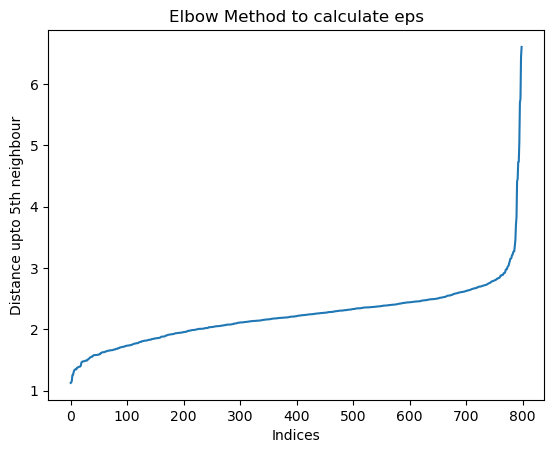

In [9]:
from sklearn.neighbors import NearestNeighbors
import matplotlib.pyplot as plt

min_samples = 5

nns = NearestNeighbors(n_neighbors=min_samples).fit(X)
dists, indxs = nns.kneighbors(X)

sorted_dists = np.sort(dists[:, min_samples-1])
plt.plot(np.arange(len(X)), sorted_dists)
plt.xlabel('Indices')
plt.ylabel(f'Distance upto {min_samples}th neighbour')
plt.title('Elbow Method to calculate eps')
plt.show()

## Applying DBScan for clustering

In [14]:
# Observed from the above Graph
eps = 1.5

In [25]:
from sklearn.cluster import DBSCAN

# Assuming you have your data in a variable called 'data'
db = DBSCAN(eps=eps, min_samples=min_samples).fit(X)
labels = db.labels_

# Number of clusters in labels, ignoring noise if present.
n_clusters_ = len(set(labels)) - (1 if -1 in labels else 0)
n_noise_ = list(labels).count(-1)

print("Estimated number of clusters: %d" % n_clusters_)
print("Estimated number of noise points: %d" % n_noise_)
print(f"Estimated number of clustered points: {799 - n_noise_}\n")

num_points = {}
for i in range(len(labels)):
    if num_points.get(labels[i]) == None:
        num_points[labels[i]] = 1
    else: 
        num_points[labels[i]] += 1
        
num_points.pop(-1)
for i, val in enumerate(num_points):
    print(f'Cluster {i+1} contains {num_points[val]} points')

Estimated number of clusters: 11
Estimated number of noise points: 733
Estimated number of clustered points: 66

Cluster 1 contains 5 points
Cluster 2 contains 6 points
Cluster 3 contains 6 points
Cluster 4 contains 11 points
Cluster 5 contains 6 points
Cluster 6 contains 5 points
Cluster 7 contains 5 points
Cluster 8 contains 5 points
Cluster 9 contains 6 points
Cluster 10 contains 5 points
Cluster 11 contains 6 points


(799, 2)


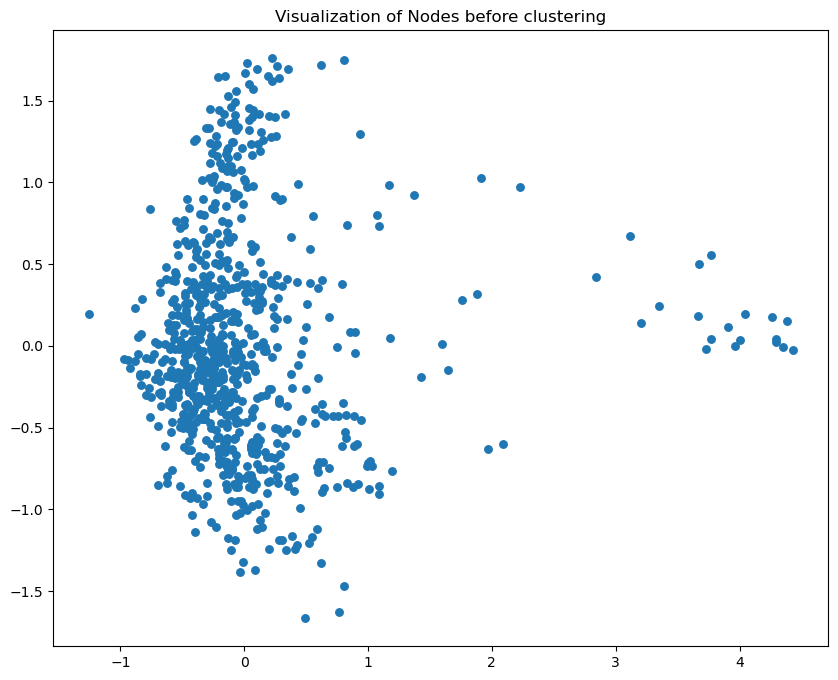

In [16]:
from sklearn.decomposition import PCA

pca = PCA(n_components=2).fit(X)
X_2d = pca.transform(X)
print(X_2d.shape)

points_whole_ax = 5 * 0.8 * 72    
radius = 0.05
points_radius = 2 * radius / 1.0 * points_whole_ax
fig, ax = plt.subplots(figsize=(10, 8))
ax.scatter(X_2d[:, 0], X_2d[:, 1], s=points_radius)
ax.set_title('Visualization of Nodes before clustering')

plt.show()

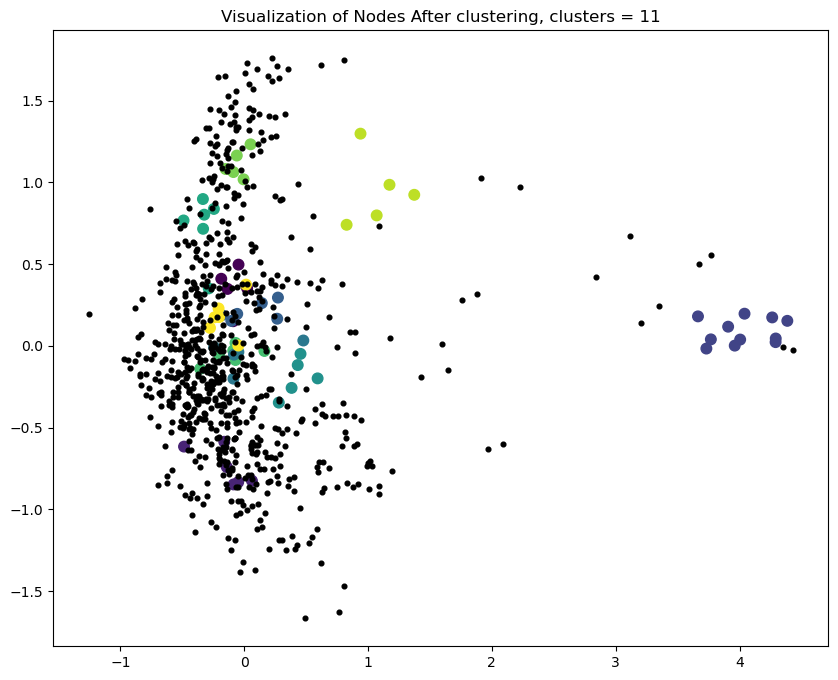

In [17]:
fig, ax = plt.subplots(figsize=(10, 8))
points_whole_ax = 5 * 0.8 * 72    
radius = 0.1
points_radius = 2 * radius / 1.0 * points_whole_ax

plt_labels =[]
for i in range(labels.size):
    if labels[i] >=0:
        plt_labels.append(labels[i])
ax.scatter(X_2d[labels!=-1, 0], X_2d[labels!=-1, 1], c=plt_labels, s= points_radius)
ax.scatter(X_2d[labels==-1, 0], X_2d[labels ==-1, 1], c='k', s= 0.2*points_radius)
# ax.legend()
ax.set_title(f'Visualization of Nodes After clustering, clusters = {n_clusters_}')

plt.show()